In [72]:
# Import libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [73]:
# Load data
df = pd.read_csv('SMDG_results.csv')

# Remove rows with missing values
df = df.dropna()

# Remove rows where glaucoma is not 0 or 1
# df = df[df['glaucoma'].isin([0, 1])]

# Remove unnecesary columns
keep = ['filename', 'glaucoma'] + [col for col in df.columns if 'pcdr_' in col]
df = df[keep]

# Keep only rows with filename starting with 'ORIGA'
df = df[df['filename'].str.startswith('ORIGA')]

# Cap pcdr_ values to 1
df[df.iloc[:, 2:] > 1] = 1

# Keep only rows that have pcdr_ values (lb, ub]
lb = 0 ; ub = 1
df = df[(df.iloc[:, 2:] <= lb).any(axis=1).__invert__() & (df.iloc[:, 2:] > ub).any(axis=1).__invert__()]

# Remove rows with all pcdr_ values equal to 1
df = df[(df.iloc[:, 2:] == 1).all(axis=1).__invert__()]

# Split data into train and test
seed = np.random.randint(0, 10000)
np.random.seed(seed)
train = df.sample(frac=0.8)
test = df.drop(train.index)
print('Train:', train.shape[0])
print('Test:', test.shape[0])
print('#############################################')
print('Images suitable for analysis:', df.shape[0])
print('Glaucoma:', (df['glaucoma'] == 1).sum())
print('Non glaucoma:', (df['glaucoma'] == 0).sum())
print('Glaucoma-suspect:', (df['glaucoma'] == -1).sum())

Train: 482
Test: 120
#############################################
Images suitable for analysis: 602
Glaucoma: 141
Non glaucoma: 461
Glaucoma-suspect: 0


**Disclaimer**

- Disc, cup and fovea segmentations are done using segmentation CNNs. Very useful for large batches of data but can generate some weird segmentations, especially in low quality fundus images.

**Excluding rules**

- All pCDR values == 1: ellipses fitted to cup and disc segmentations are equal or almost equal.
  
- pCDR values very low: generally caused by the disc segmentation not being great (disc surrounding tissue, pathology near disc, disc edge barely visible...).
  
- pCDR values > 1: disc and cup ellipses are very very close together and, mathematically, the calculation of the intersection points leads to the cup_points going over the disc_points.

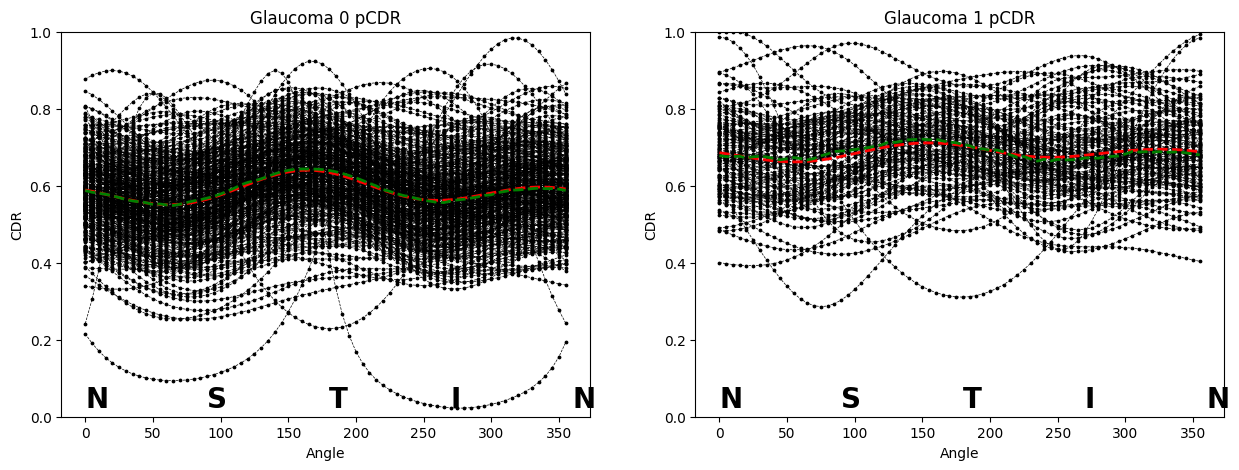

In [79]:
# Group by glaucoma status
df_grouped = train.groupby('glaucoma')

# Plot pcdr values
plt.figure(figsize=(15, 5))
# Number of groups to plot
n_groups = len(df_grouped)
for i, (name, group) in enumerate(df_grouped):
    plt.subplot(1, n_groups, i + 1)
    group = group.drop(['filename', 'glaucoma'], axis=1)
    cdr = group.values.T
    angles = [int(col.split('_')[1]) for col in group.columns if col.startswith('pcdr_')]
    angles = np.tile(angles, (cdr.shape[1], 1)).T # Make angles same shape as cdr for plotting
    plt.plot(angles, cdr, 'k--', linewidth=0.5)
    plt.scatter(angles, cdr, s=3, c='k')
    
    # Plot mean and median
    mean_cdr = np.mean(cdr, axis=1)
    median_cdr = np.median(cdr, axis=1)
    plt.plot(angles[:, 0], mean_cdr, 'r--', linewidth=2)
    plt.plot(angles[:, 0], median_cdr, 'g--', linewidth=2)
    
    # Overlay N S T I N labels on top of the X axis
    angle = [0, 90, 180, 270, 360]
    quadrant = ['N', 'S', 'T', 'I', 'N']
    for a, q in zip(angle, quadrant):
        plt.text(a, 0.025, q, fontsize=20, color='k', fontweight='bold')
    
    plt.title(f'Glaucoma {name} pCDR')
    plt.xlabel('Angle')
    plt.ylabel('CDR')
    plt.ylim(0, 1)
    
plt.show()

In [80]:
# Define method to calculate Mahalanobis distance
def mahalanobis(x, mu, cov):
    """
    Calculate Mahalanobis distance between two vectors x and mu using covariance matrix cov.
    
    Parameters
    ----------
    x : (N,M) array_like
        Input array.
    mu : (N,) array_like
        Mean vector of the distribution.
    cov : (N,N) array_like
        Covariance matrix of the distribution.
        
    """
    
    inv_cov = np.linalg.inv(cov)
    delta = x - mu
    m = np.dot(np.dot(delta, inv_cov), delta.T)
    out = np.sqrt(m)
    return out

# Calculate Mahalanobis distance for each group
cov_matrices = {}
mean_vectors = {}
for name, group in df_grouped:
    # Covariance matrix
    cov = np.cov(group.iloc[:, 2:].values.T)
    # Add covariance matrix to dictionary
    cov_matrices.update({name: cov})
    # Add mean vector to dictionary
    mean_vectors.update({name: np.mean(group.iloc[:, 2:].values, axis=0)})

Prior probability of glaucoma: 0.23858921161825727
#############################################
Log prior odds: -1.1604297196913202
Posterior odds information
count    1.180000e+02
mean     2.089906e-01
std      6.347299e-01
min      2.484789e-85
25%      2.258536e-02
50%      7.705301e-02
75%      2.205169e-01
max      6.665048e+00
Name: log_posterior_odds, dtype: float64


/tmp/ipykernel_798737/2814650398.py:20: RuntimeWarning: invalid value encountered in sqrt
  out = np.sqrt(m)
/tmp/ipykernel_798737/2814650398.py:20: RuntimeWarning: invalid value encountered in sqrt
  out = np.sqrt(m)


Text(0.5, 1.0, 'Posterior probability of patients (test set)')

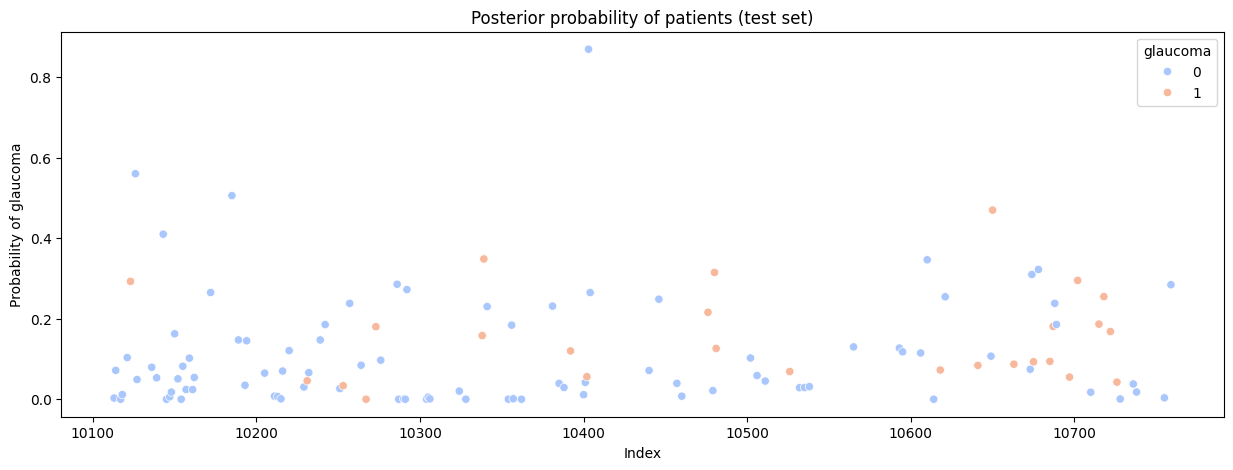

In [81]:
# Calculate Mahalanobis distance on test for each group
test2 = pd.DataFrame(index=test.index)
for k, v in cov_matrices.items():
    mu = mean_vectors.get(k)
    x = test.iloc[:, 2:].values
    mahal = mahalanobis(x=x, mu=mu, cov=v)
    # Add Mahalanobis distance to test2
    col_name = f'mahalanobis_{k}'
    test2[col_name] = mahal.diagonal()
    
# Prior probability of glaucoma
prior_glaucoma = (train['glaucoma'] == 1).sum() / ((train['glaucoma'] == 1).sum() + (train['glaucoma'] == 0).sum())
print('Prior probability of glaucoma:', prior_glaucoma)
print('#############################################')

# log(posterior odds) = log(prior odds) + 0.5 * (mahalanobis_0 - mahalanobis_1)
DDI = test2['mahalanobis_0'] - test2['mahalanobis_1']
log_prior_odds = np.log(prior_glaucoma / (1 - prior_glaucoma))
test2['log_posterior_odds'] = log_prior_odds + 0.5 * DDI
# Print DDI distribution information
print(f'Log prior odds: {log_prior_odds}')
# Posterior odds information
print('Posterior odds information')
print(np.exp(test2['log_posterior_odds']).describe())

# Posterior probability of glaucoma
test2['posterior_probability'] = 1 / (1 + np.exp(-test2['log_posterior_odds']))

# Scatter plot of posterior probability of suspected glaucoma
plt.figure(figsize=(15, 5))
sns.scatterplot(x=test2.index, y=test2['posterior_probability'], hue=test['glaucoma'], palette='coolwarm')
plt.xlabel('Index')
plt.ylabel('Probability of glaucoma')
plt.title('Posterior probability of patients (test set)')